# Experiment 4.2.3: Gaussian Process Regression (2D)

This notebook evaluates the effectiveness of different point sets for Gaussian Process Regression (GPR) in 2D.

**Outline:**
1. Load optimal Korobov parameters from Table korobov_optimal_a
2. Define benchmark test functions (2D)
3. Generate point sets using different methods
4. Fit GPR models using sampled data
5. Compute $L^2$ approximation error via numerical integration
6. Compare performance across point set types

## Setup

In [1]:
# Uncomment for Google Colab
# !pip install numpy scipy matplotlib qmcpy scikit-learn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from math import gcd
from functools import reduce
from typing import List, Tuple, Optional, Callable
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn for GPR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C

# Import from lattice_qmc package
from lattice_qmc import KorobovLattice, ExplicitRank1Lattice
from lattice_qmc.utils import generate_primes, compute_separation_radius_fast

# QMCPy for Halton and Sobol
try:
    import qmcpy as qp
    QMCPY_AVAILABLE = True
    print("QMCPy loaded successfully.")
except ImportError:
    QMCPY_AVAILABLE = False
    print("QMCPy not available. Install with: pip install qmcpy")

# Publication-quality plot settings
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 10,
    'figure.figsize': (10, 7),
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

np.random.seed(42)
print("Setup complete!")

QMCPy loaded successfully.
Setup complete!


## Helper Functions for Other Point Sets

In [3]:
# ============================================================
# Other Point Set Generators
# ============================================================

def generate_random_points(n: int, d: int, seed: int = None) -> np.ndarray:
    if seed is not None:
        np.random.seed(seed)
    return np.random.rand(n, d)

def generate_halton_points(n: int, d: int) -> np.ndarray:
    if not QMCPY_AVAILABLE:
        raise ImportError("QMCPy required for Halton sequences.")
    halton = qp.Halton(d, seed=42)
    return halton.gen_samples(n)

def generate_sobol_points(n: int, d: int) -> np.ndarray:
    if not QMCPY_AVAILABLE:
        raise ImportError("QMCPy required for Sobol sequences.")
    sobol = qp.Sobol(d, seed=42)
    return sobol.gen_samples(n)

print("Point set generators loaded.")

Point set generators loaded.


## Load Optimal Korobov Parameters

In [4]:
# Load optimal Korobov parameters from experiment 4.1.1
try:
    korobov_params = np.load('data/korobov_optimal_parameters.npy', allow_pickle=True).item()
    korobov_primes = korobov_params['primes']
    optimal_generators = korobov_params['optimal_generators']
    print("Loaded optimal Korobov parameters from file.")
    print(f"Available dimensions: {list(optimal_generators.keys())}")
    # Use the same Korobov primes and generators as in 04_01_03 (first 9 primes)
    korobov_primes_2d = korobov_primes[2:9]
    korobov_generators_2d = optimal_generators[2][2:9] if optimal_generators is not None else None
    print(f"\nSelected primes for 2D: {korobov_primes_2d}")
    print(f"Optimal generators a* for d=2: {korobov_generators_2d}")
except FileNotFoundError:
    print("Warning: Could not load optimal parameters. Using default primes.")
    korobov_primes_2d = [13, 31, 61, 127, 251, 509, 1021]
    korobov_generators_2d = None
    optimal_generators = None

Loaded optimal Korobov parameters from file.
Available dimensions: [2, 3, 5, 7]

Selected primes for 2D: [  13   31   61  127  251  509 1021]
Optimal generators a* for d=2: [8, 12, 53, 115, 177, 376, 798]


---

## Part 1: 2D Test Function

### 1.1 Define the Test Function

We use the **Franke function**, a standard benchmark for 2D interpolation:

$$
f(x, y) = \frac{3}{4} e^{-\frac{(9x-2)^2 + (9y-2)^2}{4}} + \frac{3}{4} e^{-\frac{(9x+1)^2}{49} - \frac{9y+1}{10}} + \frac{1}{2} e^{-\frac{(9x-7)^2 + (9y-3)^2}{4}} - \frac{1}{5} e^{-(9x-4)^2 - (9y-7)^2}
$$

This function has multiple peaks and valleys, making it a good test for interpolation methods.

In [5]:
def franke_function(X: np.ndarray) -> np.ndarray:
    """
    Franke's test function for 2D interpolation.
    
    Parameters
    ----------
    X : np.ndarray
        Points of shape (n, 2) in [0, 1]^2.
    
    Returns
    -------
    np.ndarray
        Function values of shape (n,).
    """
    x, y = X[:, 0], X[:, 1]
    
    term1 = 0.75 * np.exp(-((9*x - 2)**2 + (9*y - 2)**2) / 4)
    term2 = 0.75 * np.exp(-((9*x + 1)**2 / 49) - (9*y + 1) / 10)
    term3 = 0.5 * np.exp(-((9*x - 7)**2 + (9*y - 3)**2) / 4)
    term4 = -0.2 * np.exp(-(9*x - 4)**2 - (9*y - 7)**2)
    
    return term1 + term2 + term3 + term4


# Test the function
test_points = np.array([[0.5, 0.5], [0.0, 0.0], [1.0, 1.0]])
print("Franke function values at test points:")
print(franke_function(test_points))

Franke function values at test points:
[0.32576209 0.76642059 0.03586959]


### Additional Test Functions

We include three additional test functions adapted from standard benchmarks. The original functions are defined on $[-1,1]^2$ (unit disk centered at origin), so we transform them to $[0,1]^2$ by substituting $x \to 2x-1$ and $y \to 2y-1$.

**Arctan Function (adapted):**
$$u_6(x,y) = arctan(2(2x + 6y - 5)) / arctan(2(\sqrt(10) + 1))$$

**Gaussian Peak (adapted):**
$$u_3(x,y) = \exp\left(-\left((2x - 1.1)^2 + 0.5(2y-1)^2\right)\right)$$

**Oscillatory Function (adapted):**
$$u_5(x,y) = \sin\left(\pi \left((2x-1)^2 + (2y-1)^2\right)\right)$$

In [6]:
def arctan_function(X: np.ndarray) -> np.ndarray:
    """
    Arctan test function adapted to [0, 1]^2.
    
    Original: u_6(x,y) = arctan(2(x + 3y - 1)) / arctan(2(sqrt(10) + 1)) on [-1,1]^2
    Adapted: substituting x -> 2x-1, y -> 2y-1
    
    Parameters
    ----------
    X : np.ndarray
        Points of shape (n, 2) in [0, 1]^2.
    
    Returns
    -------
    np.ndarray
        Function values of shape (n,).
    """
    x, y = X[:, 0], X[:, 1]
    # Transform to [-1, 1]^2 centered coordinates
    x_t = 2*x - 1
    y_t = 2*y - 1
    
    normalizer = np.arctan(2 * (np.sqrt(10) + 1))
    return np.arctan(2 * (x_t + 3*y_t - 1)) / normalizer


def gaussian_peak(X: np.ndarray) -> np.ndarray:
    """
    Gaussian peak test function adapted to [0, 1]^2.
    
    Original: u_3(x,y) = exp(-((x - 0.1)^2 + 0.5*y^2)) on [-1,1]^2
    Adapted: substituting x -> 2x-1, y -> 2y-1
    
    Parameters
    ----------
    X : np.ndarray
        Points of shape (n, 2) in [0, 1]^2.
    
    Returns
    -------
    np.ndarray
        Function values of shape (n,).
    """
    x, y = X[:, 0], X[:, 1]
    # Transform to [-1, 1]^2 centered coordinates
    x_t = 2*x - 1
    y_t = 2*y - 1
    
    return np.exp(-((x_t - 0.1)**2 + 0.5*y_t**2))


def oscillatory_function(X: np.ndarray) -> np.ndarray:
    """
    Oscillatory test function adapted to [0, 1]^2.
    
    Original: u_5(x,y) = sin(π * (x^2 + y^2)) on [-1,1]^2
    Adapted: substituting x -> 2x-1, y -> 2y-1
    
    Parameters
    ----------
    X : np.ndarray
        Points of shape (n, 2) in [0, 1]^2.
    
    Returns
    -------
    np.ndarray
        Function values of shape (n,).
    """
    x, y = X[:, 0], X[:, 1]
    # Transform to [-1, 1]^2 centered coordinates
    x_t = 2*x - 1
    y_t = 2*y - 1
    
    return np.sin(np.pi * (x_t**2 + y_t**2))


# Test the additional functions
test_points = np.array([[0.5, 0.5], [0.0, 0.0], [1.0, 1.0]])
print("Additional test functions at test points:")
print(f"arctan function: {arctan_function(test_points)}")
print(f"Gaussian peak: {gaussian_peak(test_points)}")
print(f"Oscillatory function: {oscillatory_function(test_points)}")

Additional test functions at test points:
arctan function: [-0.76289703 -1.01370206  0.96858209]
Gaussian peak: [0.99004983 0.18086579 0.26982006]
Oscillatory function: [ 0.0000000e+00 -2.4492936e-16 -2.4492936e-16]


### 1.2 Visualize the Test Function

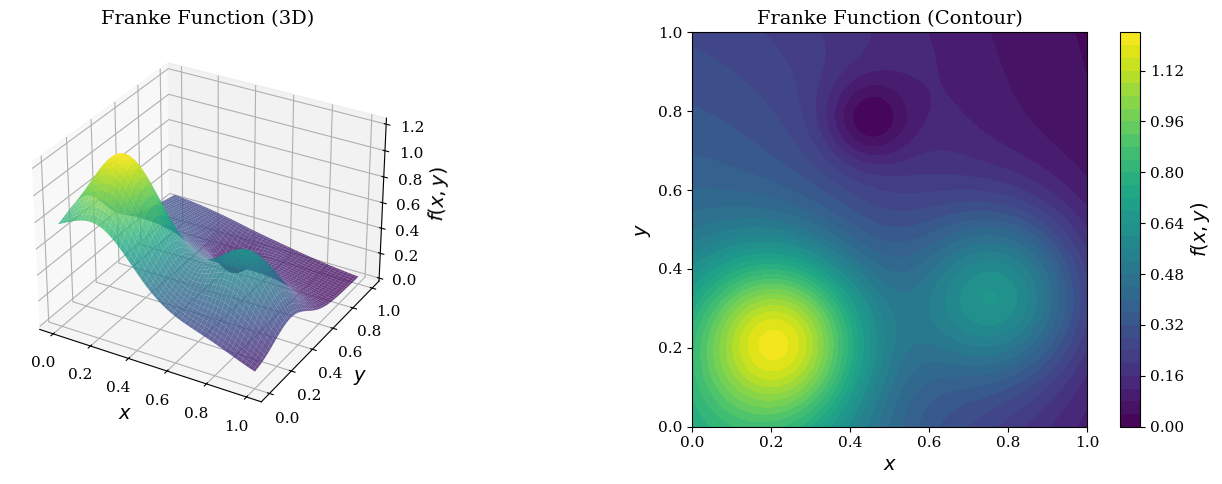

In [7]:
# Create a fine grid for visualization
n_grid = 100
x_grid = np.linspace(0, 1, n_grid)
y_grid = np.linspace(0, 1, n_grid)
X_mesh, Y_mesh = np.meshgrid(x_grid, y_grid)
XY_grid = np.column_stack([X_mesh.ravel(), Y_mesh.ravel()])
Z_true = franke_function(XY_grid).reshape(n_grid, n_grid)

# Plot
fig = plt.figure(figsize=(14, 5))

# 3D surface plot
ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X_mesh, Y_mesh, Z_true, cmap=cm.viridis, 
                        linewidth=0, antialiased=True, alpha=0.8)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_zlabel('$f(x, y)$')
ax1.set_title('Franke Function (3D)')

# Contour plot
ax2 = fig.add_subplot(122)
contour = ax2.contourf(X_mesh, Y_mesh, Z_true, levels=30, cmap=cm.viridis)
plt.colorbar(contour, ax=ax2, label='$f(x, y)$')
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_title('Franke Function (Contour)')
ax2.set_aspect('equal')

plt.tight_layout()
plt.savefig('franke_function_2d.png', dpi=150)
plt.show()

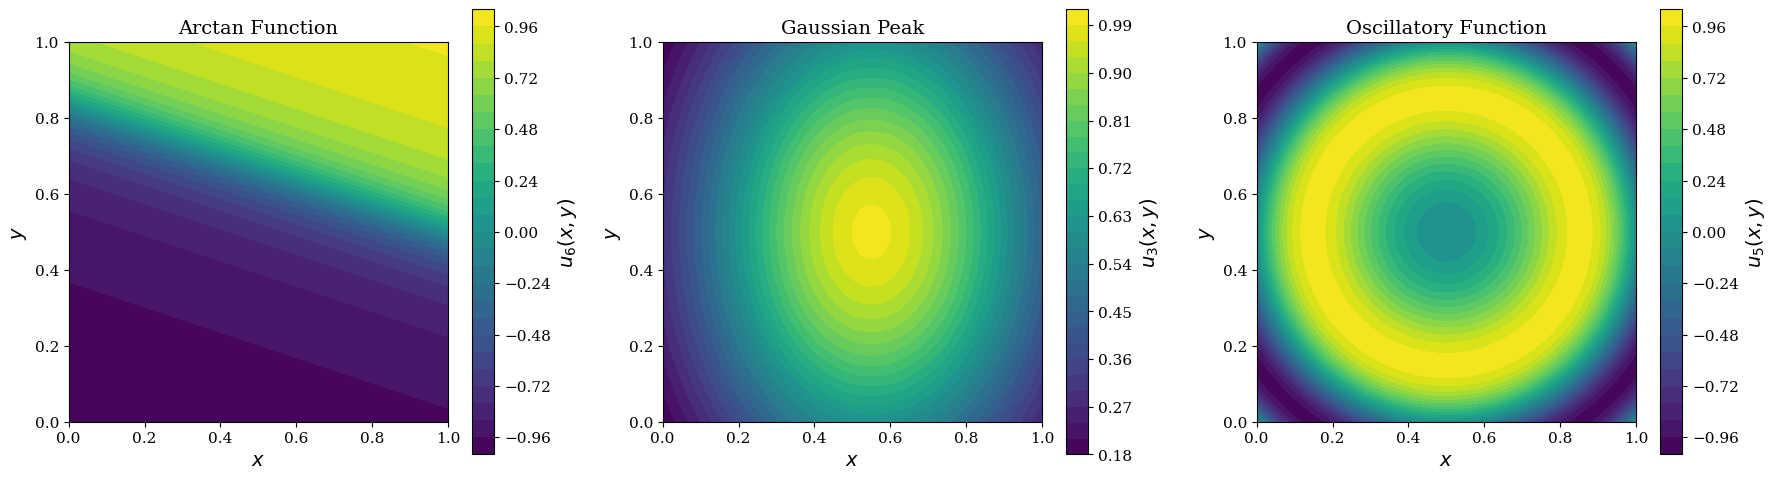

In [8]:
# Visualize additional test functions (arctan, Gaussian Peak, Oscillatory)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Arctan function
Z_arctan = arctan_function(XY_grid).reshape(n_grid, n_grid)
ax = axes[0]
c = ax.contourf(X_mesh, Y_mesh, Z_arctan, levels=30, cmap=cm.viridis)
plt.colorbar(c, ax=ax, label='$u_6(x, y)$')
ax.set_title('Arctan Function')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')

# Gaussian peak
Z_gaussian = gaussian_peak(XY_grid).reshape(n_grid, n_grid)
ax = axes[1]
c = ax.contourf(X_mesh, Y_mesh, Z_gaussian, levels=30, cmap=cm.viridis)
plt.colorbar(c, ax=ax, label='$u_3(x, y)$')
ax.set_title('Gaussian Peak')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')

# Oscillatory function
Z_oscillatory = oscillatory_function(XY_grid).reshape(n_grid, n_grid)
ax = axes[2]
c = ax.contourf(X_mesh, Y_mesh, Z_oscillatory, levels=30, cmap=cm.viridis)
plt.colorbar(c, ax=ax, label='$u_5(x, y)$')
ax.set_title('Oscillatory Function')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('test_functions_2d.png', dpi=150)
plt.show()

### 1.3 GPR Implementation and L² Error Computation

In [9]:
def fit_gpr(X_train: np.ndarray, y_train: np.ndarray, 
            kernel=None, alpha: float = 1e-6) -> GaussianProcessRegressor:
    """
    Fit a Gaussian Process Regressor.
    
    Parameters
    ----------
    X_train : np.ndarray
        Training points of shape (n, d).
    y_train : np.ndarray
        Training values of shape (n,).
    kernel : sklearn kernel, optional
        GP kernel. If None, uses Matern kernel.
    alpha : float
        Noise level (regularization).
    
    Returns
    -------
    GaussianProcessRegressor
        Fitted GPR model.
    """
    if kernel is None:
        # Use Matern kernel with automatic hyperparameter optimization
        kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=0.2, 
                                               length_scale_bounds=(1e-2, 1e1),
                                               nu=2.5)
    
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, 
                                   n_restarts_optimizer=3,
                                   normalize_y=True)
    gpr.fit(X_train, y_train)
    return gpr


def compute_l2_error(gpr: GaussianProcessRegressor, 
                     true_func: Callable,
                     d: int,
                     n_quad: int = 50) -> float:
    """
    Compute L² error of GPR approximation via numerical integration.
    
    ||f - f_GPR||_{L²}² = ∫_{[0,1]^d} |f(x) - f_GPR(x)|² dx
    
    Uses tensor product Gauss-Legendre quadrature.
    """
    # Gauss-Legendre quadrature on [0, 1]
    nodes_1d, weights_1d = np.polynomial.legendre.leggauss(n_quad)
    nodes_1d = 0.5 * (nodes_1d + 1)
    weights_1d = 0.5 * weights_1d
    
    # Tensor product quadrature
    if d == 2:
        X1, X2 = np.meshgrid(nodes_1d, nodes_1d)
        W1, W2 = np.meshgrid(weights_1d, weights_1d)
        X_quad = np.column_stack([X1.ravel(), X2.ravel()])
        weights = (W1 * W2).ravel()
    else:
        grids = np.meshgrid(*[nodes_1d]*d, indexing='ij')
        X_quad = np.column_stack([g.ravel() for g in grids])
        weight_grids = np.meshgrid(*[weights_1d]*d, indexing='ij')
        weights = np.prod([w.ravel() for w in weight_grids], axis=0)
    
    f_true = true_func(X_quad)
    f_gpr = gpr.predict(X_quad)
    squared_error = (f_true - f_gpr)**2
    l2_error_sq = np.sum(weights * squared_error)
    
    return np.sqrt(l2_error_sq)


# Configuration for noisy observations
NOISE_STD = 0.05  # Standard deviation of observation noise
N_TRIALS = 100    # Number of Monte Carlo trials

print(f"GPR functions loaded.")
print(f"Noise std: {NOISE_STD}, Number of trials: {N_TRIALS}")

GPR functions loaded.
Noise std: 0.05, Number of trials: 100


### 1.4 Test GPR with a Single Point Set (Quick Check)

In [19]:
# Quick test with Korobov lattice (single noisy trial)
d = 2
N_test = 47

print(f"Testing GPR with Korobov lattice (d={d}, N={N_test})...")
print(f"  Observation noise std: {NOISE_STD}")

# Generate points
korobov = KorobovLattice(d=d, N=N_test)
X_train = korobov.points
y_true = franke_function(X_train)

# Add observation noise
np.random.seed(42)
y_train = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)

print(f"  Training points: {X_train.shape[0]}")

# Fit GPR
gpr = fit_gpr(X_train, y_train)
print(f"  GPR fitted with kernel: {gpr.kernel_}")

# Compute L² error
l2_error = compute_l2_error(gpr, franke_function, d=d, n_quad=50)
print(f"  L² error (single trial): {l2_error:.6e}")

Testing GPR with Korobov lattice (d=2, N=47)...
  Observation noise std: 0.05
  Training points: 47
  GPR fitted with kernel: 0.835**2 * Matern(length_scale=0.247, nu=2.5)
  L² error (single trial): 4.454261e-02


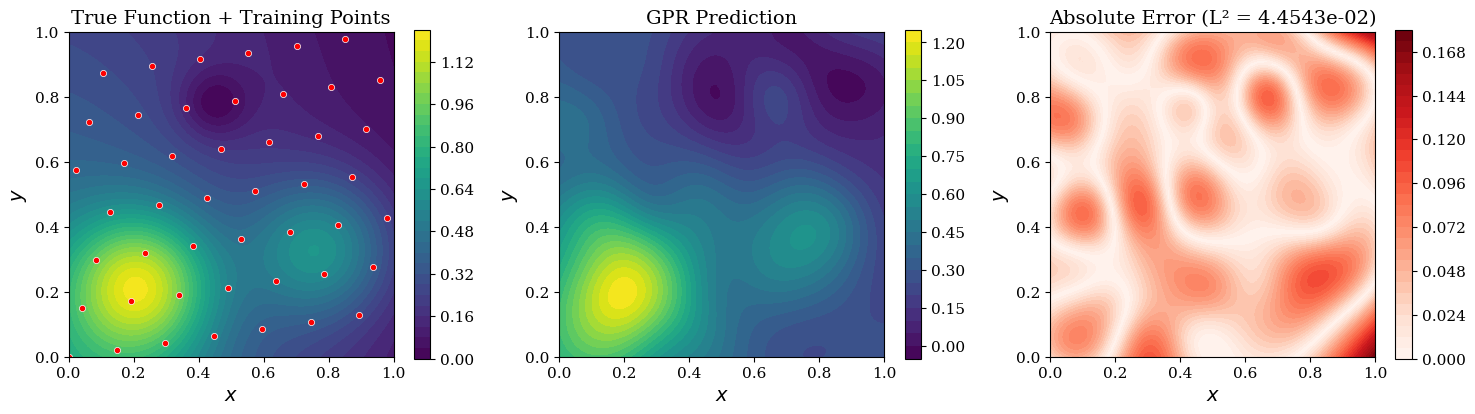

In [20]:
# Visualize the GPR fit
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# True function
ax1 = axes[0]
c1 = ax1.contourf(X_mesh, Y_mesh, Z_true, levels=30, cmap=cm.viridis)
ax1.scatter(X_train[:, 0], X_train[:, 1], c='red', s=20, marker='o', 
            edgecolors='white', linewidth=0.5, label='Training points')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_title('True Function + Training Points')
ax1.set_aspect('equal')
plt.colorbar(c1, ax=ax1)

# GPR prediction
Z_gpr = gpr.predict(XY_grid).reshape(n_grid, n_grid)
ax2 = axes[1]
c2 = ax2.contourf(X_mesh, Y_mesh, Z_gpr, levels=30, cmap=cm.viridis)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_title('GPR Prediction')
ax2.set_aspect('equal')
plt.colorbar(c2, ax=ax2)

# Error
Z_error = np.abs(Z_true - Z_gpr)
ax3 = axes[2]
c3 = ax3.contourf(X_mesh, Y_mesh, Z_error, levels=30, cmap=cm.Reds)
ax3.set_xlabel('$x$')
ax3.set_ylabel('$y$')
ax3.set_title(f'Absolute Error (L² = {l2_error:.4e})')
ax3.set_aspect('equal')
plt.colorbar(c3, ax=ax3)

plt.tight_layout()
plt.savefig('gpr_test_korobov_2d.png', dpi=150)
plt.show()

### 1.5 Run Full Comparison Experiment (2D)

In [10]:
# Configuration for 2D experiment
d = 2

# Point counts for each method (updated to use optimal parameters)
# korobov_primes_2d and korobov_generators_2d are loaded above
# Use the same explicit m as in 04_01_03
explicit_m_by_d = {2: 7, 3: 12, 5: 10, 7: 5}  # from 04_01_03
explicit_m_2d = explicit_m_by_d[2]
explicit_m_values_2d = list(range(3, explicit_m_2d + 1))
powers = [16, 32, 64, 128, 256, 512, 1024]

print(f"Running GPR comparison experiment for d = {d}")
print(f"Korobov primes (with optimal a*): {korobov_primes_2d}")
print(f"Explicit rank-1 lattice: m = {explicit_m_2d}")
print(f"  Explicit m values: {explicit_m_values_2d}")
print(f"  Powers for random/halton/sobol: {powers}")

Running GPR comparison experiment for d = 2
Korobov primes (with optimal a*): [  13   31   61  127  251  509 1021]
Explicit rank-1 lattice: m = 7
  Explicit m values: [3, 4, 5, 6, 7]
  Powers for random/halton/sobol: [16, 32, 64, 128, 256, 512, 1024]


In [11]:
def run_gpr_experiment_2d(test_func: Callable, func_name: str, n_trials: int = N_TRIALS):
    """
    Run GPR experiment for all point set types in 2D with noisy observations.
    Uses optimal Korobov generators when available.
    Each configuration is run n_trials times with different noise realizations.
    """
    results = {
        'korobov': {'N': [], 'l2_error_mean': [], 'l2_error_std': []},
        'explicit': {'N': [], 'l2_error_mean': [], 'l2_error_std': []},
        'random': {'N': [], 'l2_error_mean': [], 'l2_error_std': []},
        'halton': {'N': [], 'l2_error_mean': [], 'l2_error_std': []},
        'sobol': {'N': [], 'l2_error_mean': [], 'l2_error_std': []},
    }
    
    d = 2
    
    # Korobov lattices - use optimal generators
    print("\nKorobov lattices (using optimal generators from Table korobov_optimal_a):")
    for idx, N in enumerate(korobov_primes_2d):
        print(f"  N = {N}", end="")
        if korobov_generators_2d is not None:
            a_star = korobov_generators_2d[idx]
            print(f" (a*={a_star}): ", end="", flush=True)
            lattice = KorobovLattice(d=d, N=N, generator=a_star, verbose=False)
        else:
            print(": ", end="", flush=True)
            lattice = KorobovLattice(d=d, N=N, criterion="product", verbose=False)
        
        X_train = lattice.points
        y_true = test_func(X_train)
        
        errors = []
        for trial in range(n_trials):
            np.random.seed(1000 + trial)
            y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
            gpr = fit_gpr(X_train, y_noisy)
            l2_error = compute_l2_error(gpr, test_func, d=d)
            errors.append(l2_error)
        
        results['korobov']['N'].append(N)
        results['korobov']['l2_error_mean'].append(np.mean(errors))
        results['korobov']['l2_error_std'].append(np.std(errors))
        print(f"L² error = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
    
    # Explicit rank-1 lattice with p=2
    print("\nExplicit rank-1 lattice (p=2):")
    p = 2
    alpha = np.array([p**(j/(d+1)) for j in range(1, d+1)])
    for i in explicit_m_values_2d:
        lattice = ExplicitRank1Lattice(d=d, m=i, alpha=alpha, verbose=False)
        Q = lattice.Q
        if Q < 10:  # Skip small Q
            continue
        
        print(f"  m = {i}: Q = {Q}: ", end="", flush=True)
        X_train = lattice.points
        y_true = test_func(X_train)
        
        errors = []
        for trial in range(n_trials):
            np.random.seed(1000 + trial)
            y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
            gpr = fit_gpr(X_train, y_noisy)
            l2_error = compute_l2_error(gpr, test_func, d=d)
            errors.append(l2_error)
        
        results['explicit']['N'].append(Q)
        results['explicit']['l2_error_mean'].append(np.mean(errors))
        results['explicit']['l2_error_std'].append(np.std(errors))
        print(f"L² error = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
    
    # Random points
    print("\nRandom points:")
    for N in powers:
        print(f"  N = {N}: ", end="", flush=True)
        errors = []
        for trial in range(n_trials):
            X_train = generate_random_points(N, d, seed=1000 + trial)
            y_true = test_func(X_train)
            y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
            gpr = fit_gpr(X_train, y_noisy)
            l2_error = compute_l2_error(gpr, test_func, d=d)
            errors.append(l2_error)
        results['random']['N'].append(N)
        results['random']['l2_error_mean'].append(np.mean(errors))
        results['random']['l2_error_std'].append(np.std(errors))
        print(f"L² error = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
    
    # Halton points
    if QMCPY_AVAILABLE:
        print("\nHalton points:")
        for N in powers:
            print(f"  N = {N}: ", end="", flush=True)
            errors = []
            for trial in range(n_trials):
                X_train = generate_halton_points(N, d)
                y_true = test_func(X_train)
                y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
                gpr = fit_gpr(X_train, y_noisy)
                l2_error = compute_l2_error(gpr, test_func, d=d)
                errors.append(l2_error)
            results['halton']['N'].append(N)
            results['halton']['l2_error_mean'].append(np.mean(errors))
            results['halton']['l2_error_std'].append(np.std(errors))
            print(f"L² error = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
    else:
        print("QMCPy not available. Skipping Halton.")
    
    # Sobol points
    if QMCPY_AVAILABLE:
        print("\nSobol points:")
        for N in powers:
            print(f"  N = {N}: ", end="", flush=True)
            errors = []
            for trial in range(n_trials):
                X_train = generate_sobol_points(N, d)
                y_true = test_func(X_train)
                y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
                gpr = fit_gpr(X_train, y_noisy)
                l2_error = compute_l2_error(gpr, test_func, d=d)
                errors.append(l2_error)
            results['sobol']['N'].append(N)
            results['sobol']['l2_error_mean'].append(np.mean(errors))
            results['sobol']['l2_error_std'].append(np.std(errors))
            print(f"L² error = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
    else:
        print("QMCPy not available. Skipping Sobol.")
    
    return results

### 1.6 Plot Results (2D)

In [13]:
def plot_gpr_results(results: dict, d: int, func_name: str, save_fig: bool = True):
    """
    Plot L² error vs number of points with error bars.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    
    styles = {
        'korobov': {'color': '#1f77b4', 'marker': 'o', 'label': 'Korobov (ours)'},
        'explicit': {'color': '#d62728', 'marker': 's', 'label': 'Explicit (ours)'},
        'random': {'color': '#7f7f7f', 'marker': 'x', 'label': 'Random'},
        'halton': {'color': '#2ca02c', 'marker': '^', 'label': 'Halton'},
        'sobol': {'color': '#9467bd', 'marker': 'D', 'label': 'Sobol'},
    }
    
    for method, style in styles.items():
        if results[method]['N']:
            N = np.array(results[method]['N'])
            mean = np.array(results[method]['l2_error_mean'])
            std = np.array(results[method]['l2_error_std'])
            
            ax.errorbar(N, mean, yerr=std, 
                       marker=style['marker'], color=style['color'],
                       label=style['label'], linewidth=2, markersize=8,
                       capsize=3, capthick=1)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of points $N$')
    ax.set_ylabel('$L^2$ error')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    
    if save_fig:
        filename = f'gpr_error_{func_name.lower()}_{d}d'
        plt.savefig(f'{filename}.pdf')
        plt.savefig(f'{filename}.png', dpi=300)
        print(f"Saved: {filename}.pdf, {filename}.png")
    
    plt.show()
# ---


Experiment: Franke Function

Korobov lattices (using optimal generators from Table korobov_optimal_a):
  N = 13 (a*=8): L² error = 9.399993e-02 ± 8.411926e-03
  N = 31 (a*=12): L² error = 9.399993e-02 ± 8.411926e-03
  N = 31 (a*=12): L² error = 5.106886e-02 ± 5.078704e-03
  N = 61 (a*=53): L² error = 5.106886e-02 ± 5.078704e-03
  N = 61 (a*=53): L² error = 4.787168e-02 ± 4.031298e-03
  N = 127 (a*=115): L² error = 4.787168e-02 ± 4.031298e-03
  N = 127 (a*=115): L² error = 4.668347e-02 ± 2.950238e-03
  N = 251 (a*=177): L² error = 4.668347e-02 ± 2.950238e-03
  N = 251 (a*=177): L² error = 4.591542e-02 ± 1.913165e-03
  N = 509 (a*=376): L² error = 4.591542e-02 ± 1.913165e-03
  N = 509 (a*=376): L² error = 4.559833e-02 ± 1.416211e-03
  N = 1021 (a*=798): L² error = 4.559833e-02 ± 1.416211e-03
  N = 1021 (a*=798): L² error = 4.525814e-02 ± 1.013806e-03

Explicit rank-1 lattice (p=2):
  m = 3: Q = 12: L² error = 4.525814e-02 ± 1.013806e-03

Explicit rank-1 lattice (p=2):
  m = 3: Q = 12: L²

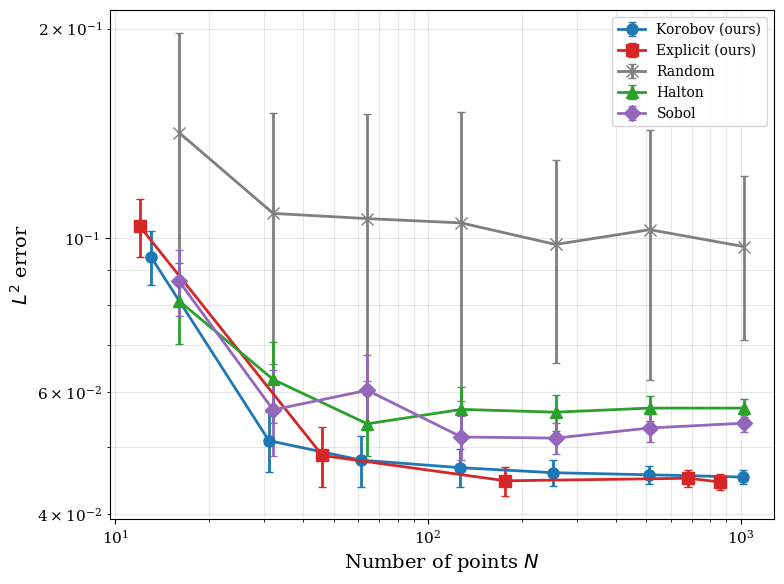

In [ ]:
# Run experiments for Franke Function
print("="*60)
print("Experiment: Franke Function")
print("="*60)
results_franke = run_gpr_experiment_2d(franke_function, "franke")
plot_gpr_results(results_franke, d=2, func_name="franke")

### 1.7 Results for Additional Test Functions

Now we run the same experiments on the three additional test functions.

Experiment: Arctan Function

Korobov lattices (using optimal generators from Table korobov_optimal_a):
  N = 13 (a*=8): L² error = 1.324139e-01 ± 8.588618e-03
  N = 31 (a*=12): L² error = 9.367364e-02 ± 7.912468e-03
  N = 61 (a*=53): L² error = 5.351362e-02 ± 5.185459e-03
  N = 127 (a*=115): L² error = 4.904303e-02 ± 3.470280e-03
  N = 251 (a*=177): L² error = 4.736481e-02 ± 2.126093e-03
  N = 509 (a*=376): L² error = 4.679102e-02 ± 1.492710e-03
  N = 1021 (a*=798): L² error = 4.614862e-02 ± 1.098047e-03

Explicit rank-1 lattice (p=2):
  m = 3: Q = 12: L² error = 2.197670e-01 ± 2.887934e-02
  m = 4: Q = 46: L² error = 5.467931e-02 ± 4.541114e-03
  m = 5: Q = 177: L² error = 5.058118e-02 ± 2.674390e-03
  m = 6: Q = 681: L² error = 4.634883e-02 ± 1.323970e-03
  m = 7: Q = 858: L² error = 4.629094e-02 ± 1.338269e-03

Random points:
  N = 16: L² error = 2.126900e-01 ± 7.148409e-02
  N = 32: L² error = 1.572295e-01 ± 7.994027e-02
  N = 64: L² error = 1.484549e-01 ± 7.450444e-02
  N = 128: L

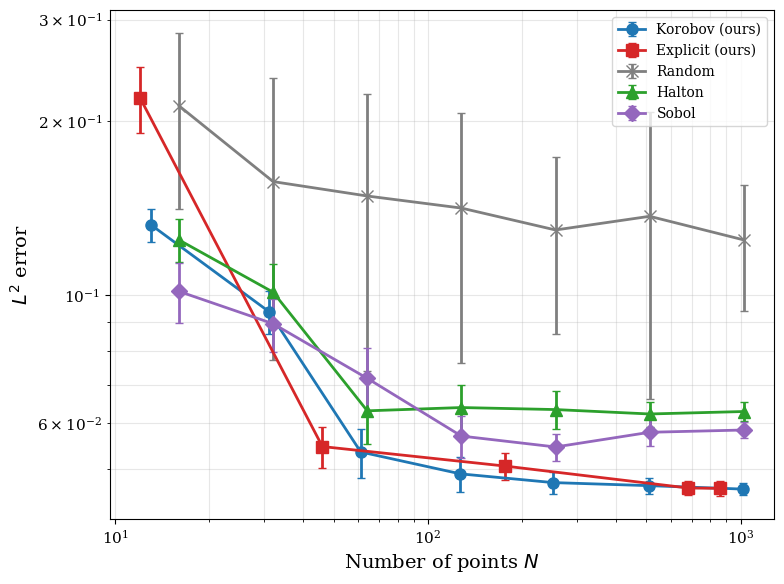

In [15]:
# Run experiments for Arctan Function
print("="*60)
print("Experiment: Arctan Function")
print("="*60)
results_arctan = run_gpr_experiment_2d(arctan_function, "Arctan")
plot_gpr_results(results_arctan, d=2, func_name="Arctan")

Experiment: Gaussian Peak

Korobov lattices (using optimal generators from Table korobov_optimal_a):
  N = 13 (a*=8): L² error = 5.815682e-02 ± 1.351874e-02
  N = 31 (a*=12): L² error = 5.815682e-02 ± 1.351874e-02
  N = 31 (a*=12): L² error = 5.008062e-02 ± 5.813582e-03
  N = 61 (a*=53): L² error = 5.008062e-02 ± 5.813582e-03
  N = 61 (a*=53): L² error = 4.846938e-02 ± 4.182581e-03
  N = 127 (a*=115): L² error = 4.846938e-02 ± 4.182581e-03
  N = 127 (a*=115): L² error = 4.723387e-02 ± 2.895259e-03
  N = 251 (a*=177): L² error = 4.723387e-02 ± 2.895259e-03
  N = 251 (a*=177): L² error = 4.594733e-02 ± 1.913487e-03
  N = 509 (a*=376): L² error = 4.594733e-02 ± 1.913487e-03
  N = 509 (a*=376): L² error = 4.554490e-02 ± 1.403482e-03
  N = 1021 (a*=798): L² error = 4.554490e-02 ± 1.403482e-03
  N = 1021 (a*=798): L² error = 4.511136e-02 ± 1.001060e-03

Explicit rank-1 lattice (p=2):
  m = 3: Q = 12: L² error = 4.511136e-02 ± 1.001060e-03

Explicit rank-1 lattice (p=2):
  m = 3: Q = 12: L² e

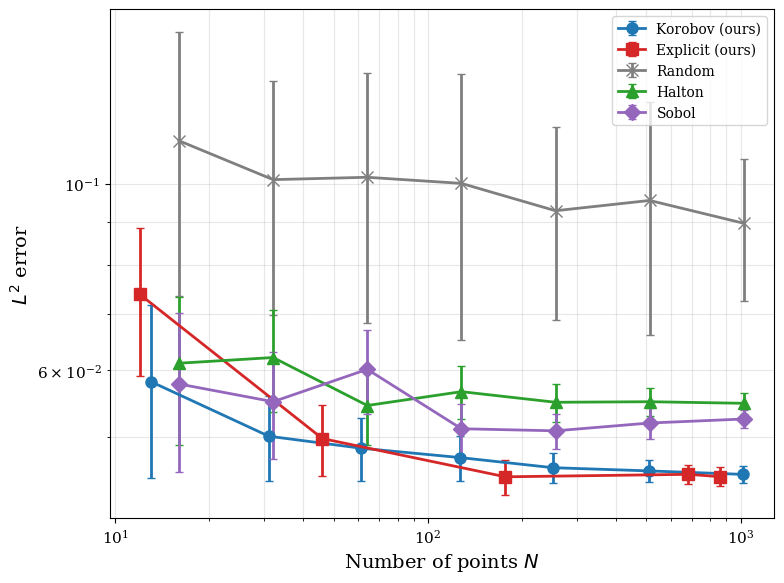

In [26]:
# Run experiments for Gaussian Peak
print("="*60)
print("Experiment: Gaussian Peak")
print("="*60)
results_gaussian = run_gpr_experiment_2d(gaussian_peak, "GaussianPeak")
plot_gpr_results(results_gaussian, d=2, func_name="GaussianPeak")

Experiment: Oscillatory Function

Korobov lattices (using optimal generators from Table korobov_optimal_a):
  N = 13 (a*=8): L² error = 6.101449e-01 ± 3.831556e-03
  N = 31 (a*=12): L² error = 6.101449e-01 ± 3.831556e-03
  N = 31 (a*=12): L² error = 3.159799e-01 ± 1.994446e-02
  N = 61 (a*=53): L² error = 3.159799e-01 ± 1.994446e-02
  N = 61 (a*=53): L² error = 1.493157e-01 ± 9.653284e-03
  N = 127 (a*=115): L² error = 1.493157e-01 ± 9.653284e-03
  N = 127 (a*=115): L² error = 7.052001e-02 ± 5.323574e-03
  N = 251 (a*=177): L² error = 7.052001e-02 ± 5.323574e-03
  N = 251 (a*=177): L² error = 5.048310e-02 ± 2.550572e-03
  N = 509 (a*=376): L² error = 5.048310e-02 ± 2.550572e-03
  N = 509 (a*=376): L² error = 4.752266e-02 ± 1.583408e-03
  N = 1021 (a*=798): L² error = 4.752266e-02 ± 1.583408e-03
  N = 1021 (a*=798): L² error = 4.622789e-02 ± 1.072925e-03

Explicit rank-1 lattice (p=2):
  m = 3: Q = 12: L² error = 4.622789e-02 ± 1.072925e-03

Explicit rank-1 lattice (p=2):
  m = 3: Q = 1

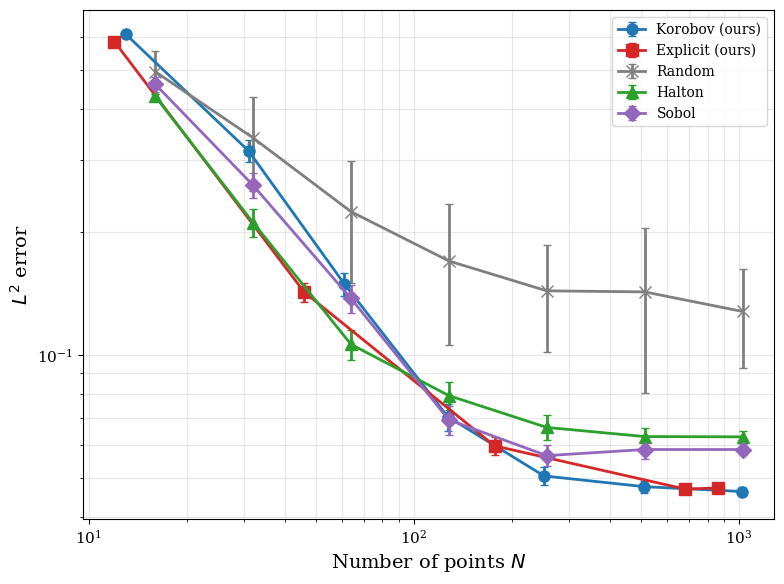

In [27]:
# Run experiments for Oscillatory Function
print("="*60)
print("Experiment: Oscillatory Function")
print("="*60)
results_oscillatory = run_gpr_experiment_2d(oscillatory_function, "Oscillatory")
plot_gpr_results(results_oscillatory, d=2, func_name="Oscillatory")